In [1]:
# Francisco Dominguez Mateos
# 24/06/2020
# I don't know how to convert from Flat to conv,..... in JAX jet
# from: https://github.com/google/jax/blob/master/examples/mnist_vae.py

In [1]:
import os
import time

import matplotlib.pyplot as plt

import jax.numpy as np
from jax import jit, grad, lax, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, FanOut, Relu, Softplus
#from examples import datasets
import torch
from torchvision import datasets, transforms
#from: https://github.com/RobertTLange/code-and-blog/blob/master/04_jax_intro/helpers.py
#!conda install -c anaconda seaborn --yes
from helpers import plot_mnist_examples
from helpers import plot_mnist_performance

In [5]:
# Set the PyTorch Data Loader for the training & test set
batch_size = 100

dsMnist=datasets.MNIST('./pytorch_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_loader = torch.utils.data.DataLoader(dsMnist, batch_size=len(dsMnist), shuffle=True)
train_iter=iter(train_loader)
train_x,train_y=next(train_iter)
print(train_x.shape)

dtMnist=datasets.MNIST('./pytorch_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_loader = torch.utils.data.DataLoader(dtMnist,batch_size=len(dtMnist), shuffle=True)
test_iter=iter(test_loader)
test_x,test_y=next(test_iter)
print(test_x.shape)


torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


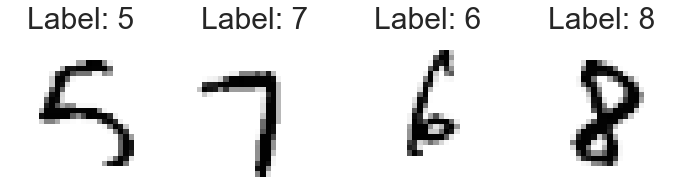

In [6]:
plot_mnist_examples(train_loader)

In [14]:
def gaussian_kl(mu, sigmasq):
  """KL divergence from a diagonal Gaussian to the standard Gaussian."""
  return -0.5 * np.sum(1. + np.log(sigmasq) - mu**2. - sigmasq)

def gaussian_sample(rng, mu, sigmasq):
  """Sample a diagonal Gaussian."""
  return mu + np.sqrt(sigmasq) * random.normal(rng, mu.shape)

def bernoulli_logpdf(logits, x):
  """Bernoulli log pdf of data x given logits."""
  return -np.sum(np.logaddexp(0., np.where(x, -1., 1.) * logits))

def elbo(rng, params, images):
  """Monte Carlo estimate of the negative evidence lower bound."""
  enc_params, dec_params = params
  mu_z, sigmasq_z = encode(enc_params, images)
  logits_x = decode(dec_params, gaussian_sample(rng, mu_z, sigmasq_z))
  return bernoulli_logpdf(logits_x, images) - gaussian_kl(mu_z, sigmasq_z)

def image_sample(rng, params, nrow, ncol):
  """Sample images from the generative model."""
  _, dec_params = params
  code_rng, img_rng = random.split(rng)
  logits = decode(dec_params, random.normal(code_rng, (nrow * ncol, 10)))
  sampled_images = random.bernoulli(img_rng, np.logaddexp(0., logits))
  return image_grid(nrow, ncol, sampled_images, (28, 28))

def image_grid(nrow, ncol, imagevecs, imshape):
  """Reshape a stack of image vectors into an image grid for plotting."""
  images = iter(imagevecs.reshape((-1,) + imshape))
  return np.vstack([np.hstack([next(images).T for _ in range(ncol)][::-1])
                    for _ in range(nrow)]).T

In [8]:
encoder_init, encode = stax.serial(
    Conv(32, (5, 5), (2, 2), padding="SAME"),
    BatchNorm(), Relu,
    Conv(32, (5, 5), (2, 2), padding="SAME"),
    BatchNorm(), Relu,
    Conv(10, (3, 3), (2, 2), padding="SAME"),
    BatchNorm(), Relu,
    Conv(10, (3, 3), (2, 2), padding="SAME"), Relu,
    Flatten,
    Dense(512), Relu,
    Dense(512), Relu,
    FanOut(2),
    stax.parallel(Dense(10), stax.serial(Dense(10), Softplus)),
)

decoder_init, decode = stax.serial(
    Dense(512), Relu,
    Dense(512), Relu,
    Dense(28 * 28),
)

In [12]:
step_size = 0.001
num_epochs = 100
batch_size = 32
nrow, ncol = 10, 10  # sampled image grid size

test_rng = random.PRNGKey(1)  # fixed prng key for evaluation
imfile = os.path.join(os.getenv("TMPDIR", "/tmp/"), "mnist_vae_{:03d}.png")

#train_images=, _, test_images, _ = datasets.mnist(permute_train=True)
train_images=np.array(train_x).reshape(train_x.size(0), 28*28)
print(train_images.shape)
test_images =np.array(test_x).reshape(test_x.size(0), 28*28)
print(test_images.shape)
num_complete_batches, leftover = divmod(train_images.shape[0], batch_size)
num_batches = num_complete_batches + bool(leftover)

(60000, 784)
(10000, 784)


In [ ]:
enc_init_rng, dec_init_rng = random.split(random.PRNGKey(2))
_, init_encoder_params = encoder_init(enc_init_rng, (batch_size, 28 * 28))
_, init_decoder_params = decoder_init(dec_init_rng, (batch_size, 10))
init_params = init_encoder_params, init_decoder_params

opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=0.9)

def binarize_batch(rng, i, images):
    i = i % num_batches
    batch = lax.dynamic_slice_in_dim(images, i * batch_size, batch_size)
    return random.bernoulli(rng, batch)

@jit
def run_epoch(rng, opt_state):
    def body_fun(i, opt_state):
        elbo_rng, data_rng = random.split(random.fold_in(rng, i))
        batch = binarize_batch(data_rng, i, train_images)
        loss = lambda params: -elbo(elbo_rng, params, batch) / batch_size
        g = grad(loss)(get_params(opt_state))
        return opt_update(i, g, opt_state)
    return lax.fori_loop(0, num_batches, body_fun, opt_state)

@jit
def evaluate(opt_state, images):
    params = get_params(opt_state)
    elbo_rng, data_rng, image_rng = random.split(test_rng, 3)
    binarized_test = random.bernoulli(data_rng, images)
    test_elbo = elbo(elbo_rng, params, binarized_test) / images.shape[0]
    sampled_images = image_sample(image_rng, params, nrow, ncol)
    return test_elbo, sampled_images

In [15]:
opt_state = opt_init(init_params)
for epoch in range(num_epochs):
    tic = time.time()
    opt_state = run_epoch(random.PRNGKey(epoch), opt_state)
    test_elbo, sampled_images = evaluate(opt_state, test_images)
    print("{: 3d} {} ({:.3f} sec)".format(epoch, test_elbo, time.time() - tic))
    plt.imsave(imfile.format(epoch), sampled_images, cmap=plt.cm.gray)

  0 -117.38753509521484 (10.813 sec)
  1 -108.02906036376953 (0.003 sec)
  2 -104.06541442871094 (0.003 sec)
  3 -102.43475341796875 (0.002 sec)
  4 -101.69845581054688 (0.002 sec)
  5 -99.95760345458984 (0.002 sec)
  6 -98.95760345458984 (0.003 sec)
  7 -98.95077514648438 (0.002 sec)
  8 -97.19876861572266 (0.002 sec)
  9 -97.80155944824219 (0.003 sec)
 10 -97.46063995361328 (0.002 sec)
 11 -97.73306274414062 (0.003 sec)
 12 -96.47126007080078 (0.002 sec)
 13 -97.353759765625 (0.002 sec)
 14 -96.53823852539062 (0.002 sec)
 15 -96.28009796142578 (0.002 sec)
 16 -95.97369384765625 (0.002 sec)
 17 -96.00509643554688 (0.003 sec)
 18 -95.28240203857422 (0.003 sec)
 19 -95.78897094726562 (0.003 sec)
 20 -95.66222381591797 (0.002 sec)
 21 -95.8922348022461 (0.002 sec)
 22 -95.60994720458984 (0.002 sec)
 23 -95.05445098876953 (0.003 sec)
 24 -94.93897247314453 (0.002 sec)
 25 -94.6717529296875 (0.002 sec)
 26 -95.46318054199219 (0.002 sec)
 27 -94.92903900146484 (0.003 sec)
 28 -95.4104843139